In [292]:
%matplotlib inline
import json
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# diversos imports que usaremos na visualização de dados
from bokeh.io import output_notebook, show
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, 
    Circle, BasicTicker, ColorBar,
    Range1d, PanTool, WheelZoomTool, BoxSelectTool, 
    HoverTool, 
)
from bokeh.models.mappers import (
    ColorMapper, LinearColorMapper,CategoricalColorMapper
)
from bokeh.plotting import figure
from bokeh.layouts import widgetbox
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.palettes import Viridis5, RdBu3


plt.style.use('fivethirtyeight')
DATASET_DIR = '../../datasets/' # Caminho para a pastaa onde fica meus datasets

In [128]:
df = pd.read_csv(
    DATASET_DIR + 'eleicao_rj/votacao_secao_2018_RJ.csv',
    sep=';',
    encoding='Latin1')
df.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,...,NM_UE,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,CD_CARGO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS
0,15/10/2018,18:30:07,2018,2,ELEIÇÃO ORDINÁRIA,1,297,ELEIÇÕES GERAIS ESTADUAIS 2018,07/10/2018,E,...,RIO DE JANEIRO,60011,RIO DE JANEIRO,7,402,7,DEPUTADO ESTADUAL,20911,ELITUSALEM GOMES DE FREITAS,1
1,15/10/2018,18:30:07,2018,2,ELEIÇÃO ORDINÁRIA,1,297,ELEIÇÕES GERAIS ESTADUAIS 2018,07/10/2018,E,...,RIO DE JANEIRO,60011,RIO DE JANEIRO,25,968,7,DEPUTADO ESTADUAL,12612,SERGIO BERNARDINO DUARTE,1
2,15/10/2018,18:30:07,2018,2,ELEIÇÃO ORDINÁRIA,1,297,ELEIÇÕES GERAIS ESTADUAIS 2018,07/10/2018,E,...,RIO DE JANEIRO,58467,MESQUITA,150,46,6,DEPUTADO FEDERAL,1000,MARCELO HODGE CRIVELLA,1
3,15/10/2018,18:30:07,2018,2,ELEIÇÃO ORDINÁRIA,1,297,ELEIÇÕES GERAIS ESTADUAIS 2018,07/10/2018,E,...,RIO DE JANEIRO,58637,NILÓPOLIS,221,117,6,DEPUTADO FEDERAL,1000,MARCELO HODGE CRIVELLA,2
4,15/10/2018,18:30:07,2018,2,ELEIÇÃO ORDINÁRIA,1,297,ELEIÇÕES GERAIS ESTADUAIS 2018,07/10/2018,E,...,RIO DE JANEIRO,58432,ITAPERUNA,107,119,6,DEPUTADO FEDERAL,1701,FRANKLIN JORGE SANTOS,1


In [4]:
rj = df.query('DS_CARGO == "GOVERNADOR" and NM_UE == "RIO DE JANEIRO"')
del df
rj2 = rj.drop([
    'DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
    'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO',
    'DT_ELEICAO', 'TP_ABRANGENCIA', 'CD_MUNICIPIO', 'SG_UF', 'SG_UE',
    'NM_UE', 'CD_CARGO', 'DS_CARGO', 'NM_MUNICIPIO', 'NR_VOTAVEL'],
    axis=1)
rj2.columns = ['zona', 'secao','candidato', 'votos'
]
rj2.to_csv(DATASET_DIR + 'eleicao_rj/limpo.csv')
del rj
rj2.loc[:, 'turno'] = 1
rj2.head(5)


,zona,secao,candidato,votos,turno
81,170,423,ANTONIO PEDRO INDIO DA COSTA,8,1
149,153,151,TARCISIO MOTTA DE CARVALHO,8,1
156,238,24,VOTO NULO,54,1
164,38,130,VOTO NULO,33,1
178,254,147,TARCISIO MOTTA DE CARVALHO,10,1


In [5]:
rj = pd.read_csv(
    DATASET_DIR + 'eleicao_rj/resultado_eleicao.csv',
    encoding='Latin1',
    sep=';')
rj.head()

,UF,Zona,Cargo,Número do candidato,Nome do candidato,Nome do candidato (urna),Partido,Coligação,Turno,Situação de totalização,Votos nominais do candidato,Votos válidos por abrangência,% votos válidos,Data última totalização
0,RJ,10,Governador,25,EDUARDO DA COSTA PAES,EDUARDO PAES,DEM,DEM / PP / MDB / PTB / SOLIDARIEDADE / PSDB / ...,2,Não eleito,29584,56420,"52,44",28/10/2018 20:16:57
1,RJ,10,Governador,20,WILSON JOSÉ WITZEL,WILSON WITZEL,PSC,PSC / PROS,2,Eleito,26836,56420,"47,56",28/10/2018 20:16:57
2,RJ,101,Governador,20,WILSON JOSÉ WITZEL,WILSON WITZEL,PSC,PSC / PROS,2,Eleito,6800,9290,"73,2",28/10/2018 20:16:57
3,RJ,101,Governador,25,EDUARDO DA COSTA PAES,EDUARDO PAES,DEM,DEM / PP / MDB / PTB / SOLIDARIEDADE / PSDB / ...,2,Não eleito,2490,9290,"26,8",28/10/2018 20:16:57
4,RJ,102,Governador,20,WILSON JOSÉ WITZEL,WILSON WITZEL,PSC,PSC / PROS,2,Eleito,5085,8706,"58,41",28/10/2018 20:16:57


In [6]:
rj = pd.read_csv(
    DATASET_DIR + 'eleicao_rj/resultado_eleicao.csv',
    encoding='Latin1',
    sep=';')
rj = rj.loc[:, [
    'Nome do candidato', 'Zona', 'Turno', 'Votos nominais do candidato'
]]
rj.columns = ['candidato', 'zona', 'turno', 'votos']
rj.head(5)

,candidato,zona,turno,votos
0,EDUARDO DA COSTA PAES,10,2,29584
1,WILSON JOSÉ WITZEL,10,2,26836
2,WILSON JOSÉ WITZEL,101,2,6800
3,EDUARDO DA COSTA PAES,101,2,2490
4,WILSON JOSÉ WITZEL,102,2,5085


## Limpeza dos dados das zonas eleitorais

In [7]:
end_zonas = pd.read_csv(
    DATASET_DIR + 'eleicao_rj/lista_zonas_eleitorais.csv',
    encoding='Latin1',
    index_col=0)
end_zonas.head()

,sigla_uf,endereco,cep,bairro,nome_municipio,sigla_uf.1
numero_zona,,,,,,
4,19-0004,RUA JARDIM BOTÂNICO 1060,22460000,JARDIM BOTÂNICO,RIO DE JANEIRO,RJ
5,19-0005,"RUA MIGUEL LEMOS, 97",22071000,COPACABANA,RIO DE JANEIRO,RJ
7,19-0007,RUA ANTONIO BASILIO 76,20511190,TIJUCA,RIO DE JANEIRO,RJ
8,19-0008,"AVENIDA DOM HÉLDER CÂMARA, 4175",20771000,DEL CASTILHO,RIO DE JANEIRO,RJ
9,19-0009,AV AYRTON SENNA 2001 BLOCO C,22775002,BARRA DA TIJUCA,RIO DE JANEIRO,RJ


In [8]:
end_zonas = end_zonas.rename(columns={'endereco': 'rua',
                                     'nome_municipio': 'municipio'})
end_zonas = end_zonas.drop(['sigla_uf', 'cep', 'sigla_uf.1'], axis=1)
end_zonas['endereco'] = end_zonas.apply(lambda x: ', '.join(x), axis=1)
colunas = ['rua', 'bairro', 'municipio', 'endereco']
for c in colunas:
    end_zonas.loc[:, c] = end_zonas.loc[:, c].apply(lambda x: x.lower())

erros = []

dados_json = []
url = 'https://maps.googleapis.com/maps/api/geocode/json'
bounds = '-23.371469,-44.917957|-20.784440,-40.504246'
with open('gkey.txt') as f:
    g_key = f.read()
for z, v in end_zonas.iterrows():
    end = v["endereco"].replace(' ', '+')
    response = requests.get(url, {
        'bounds': bounds,
        'key': g_key,
        'address': end
    })
    try:
        coords = json.loads(
            response.text)['results'][0]['geometry']['location']
        end_zonas.loc[z, 'lat'] = coords['lat']
        end_zonas.loc[z, 'lng'] = coords['lng']
        dados_json.append(response.json())
    except:
        erros.append(z)
        print(f'Não achou zona {z}')
    time.sleep(0.05)
end_zonas.loc[60, 'lat'] = -21.954952
end_zonas.loc[60, 'lng'] = -42.136810
end_zonas.loc[196, 'lat'] = -22.151659
end_zonas.loc[196, 'lng'] = -42.926066
end_zonas.index.name = 'zona'

Não achou zona 60


In [9]:
end_zonas.head()

,rua,bairro,municipio,endereco,lat,lng
zona,,,,,,
4,rua jardim botânico 1060,jardim botânico,rio de janeiro,"rua jardim botânico 1060, jardim botânico, rio...",-22.972010,-43.224547
5,"rua miguel lemos, 97",copacabana,rio de janeiro,"rua miguel lemos, 97, copacabana, rio de janeiro",-22.977688,-43.192630
7,rua antonio basilio 76,tijuca,rio de janeiro,"rua antonio basilio 76, tijuca, rio de janeiro",-22.924920,-43.235859
8,"avenida dom hélder câmara, 4175",del castilho,rio de janeiro,"avenida dom hélder câmara, 4175, del castilho,...",-22.881511,-43.274248
9,av ayrton senna 2001 bloco c,barra da tijuca,rio de janeiro,"av ayrton senna 2001 bloco c, barra da tijuca,...",-22.992552,-43.367683


## Limpando os dados do IDH

A partir dos dados do IDH Municipal, agregaremos esses dados na nossa análise de forma para enriquecermos a nossa análise.

In [10]:
idhm = pd.read_excel(
    DATASET_DIR + 'IDHM/IDHM_Municipios_RJ.xlsx', index_col=0)
idhm.head()

,Espacialidades,IDHM 2010
Código,,
76,Brasil,0.727
3300100,Angra dos Reis,0.724
3300159,Aperibé,0.692
3300209,Araruama,0.718
3300225,Areal,0.684


In [11]:
idhm.index.name = 'cod'
idhm.columns = ['municipio', 'idhm']
idhm.loc[:,'municipio'] = idhm.municipio.apply(lambda x: x.lower())
idhm.head()

,municipio,idhm
cod,,
76,brasil,0.727
3300100,angra dos reis,0.724
3300159,aperibé,0.692
3300209,araruama,0.718
3300225,areal,0.684


## Transformação dos dados dos votos
Decidi criar dois datasets diferentes, um contendo o percentual dos votos de cada zona eleitoral foi para cada candidato e o outro contendo a representatividade de votos de cada zona eleitoral em relação ao total de cada candidato.

Antes de mais nada vamos juntar os datasets dos votos em um só.

In [12]:
votos = pd.concat([
    rj2.loc[:, ['zona', 'candidato', 'votos', 'turno']].set_index('zona'),
    rj.set_index('zona')])

votos.head()
votos.tail()

,candidato,turno,votos
zona,,,
170,ANTONIO PEDRO INDIO DA COSTA,1,8
153,TARCISIO MOTTA DE CARVALHO,1,8
238,VOTO NULO,1,54
38,VOTO NULO,1,33
254,TARCISIO MOTTA DE CARVALHO,1,10


,candidato,turno,votos
zona,,,
96,EDUARDO DA COSTA PAES,2,12455
97,WILSON JOSÉ WITZEL,2,5416
97,EDUARDO DA COSTA PAES,2,2267
98,WILSON JOSÉ WITZEL,2,36180
98,EDUARDO DA COSTA PAES,2,20890


No dataframe de votos, apesar de não termos mais a coluna "seção", ainda temos os votos contabilizados dessa maneira, por isso temos os candidatos com os nomes repetidos diversas vezes em cada zona, precimas agrupar os votos por zona eleitoral.

In [13]:
antes = votos.shape[0]
print(f'Número de linhas antes do agrupamento: {antes}')
votos = np.sum(votos.groupby(['zona', 'candidato', 'turno']))
print(f'Número de linhas depois do agrupamento: {votos.shape[0]}')
print(f'Redução de {round((1-(votos.shape[0]/antes))*100, 2)}%' 
      f' na quantidade de linhas.')

Número de linhas antes do agrupamento: 390160
Número de linhas depois do agrupamento: 2638
Redução de 99.32%na quantidade de linhas.


Com o nosso dataset de votos completo, agrupado por zona eleitoral,  vamos criar mais dois datasets derivados dele: 
- um nos mostrará quanto cada zona eleitoral representou para cada candidato, em outras palavras, em quais zonas eleitorais cada candidato se saiu melhor.
- o outro nos mostrará o quanto cada candidato representou em cada urna, ou seja, quem se saiu melhor em cada urna.

In [164]:
total_zona = np.sum(votos.groupby(['zona', 'turno']))['votos']
total_candidato = np.sum(votos.groupby(['candidato',
                                        'turno'])).loc[:, 'votos']
try:
    votos_perc_por_cand = pd.read_csv(DATASET_DIR+'eleicao_rj/votos_perc_cand.csv', index_col=[0,1,2])
    votos_perc_por_zona = pd.read_csv(DATASET_DIR+'eleicao_rj/votos_perc_zona.csv', index_col=[0,1,2])
except FileNotFoundError:
    votos_perc_por_zona = pd.DataFrame()
    votos_perc_por_cand = pd.DataFrame()
    for z, c, t in votos.index.values:
        inter_zona = votos.query(
            f'zona == {z} & turno == {t} & candidato == "{c}"'
        )/total_zona[z][t]
        votos_perc_por_zona = pd.concat(
            [votos_perc_por_zona, inter_zona],
            join='outer'
        )
        inter_cand = votos.query(
            f'zona == {z} & turno == {t} & candidato == "{c}"'
        )/total_candidato[c][t]
        votos_perc_por_cand = pd.concat(
            [votos_perc_por_cand, inter_cand],
            join='outer'
        )
    votos_perc_por_cand = round(votos_perc_por_cand*100,2)
    votos_perc_por_zona = round(votos_perc_por_zona*100,2)

    votos_perc_por_zona.columns = ['%_votos']
    votos_perc_por_cand.columns = ['%_votos']
    votos_perc_por_cand.to_csv(DATASET_DIR + 'eleicao_rj/votos_perc_cand.csv')
    votos_perc_por_zona.to_csv(DATASET_DIR + 'eleicao_rj/votos_perc_zona.csv')
votos_perc_por_zona.head(10)
votos_perc_por_cand.head(10)    

%_votos
zona candidato                                     turno         
4    ANTHONY WILLIAM GAROTINHO MATHEUS DE OLIVEIRA 1         0.15
     ANTONIO PEDRO INDIO DA COSTA                  1         2.14
     DAYSE OLIVEIRA GOMES                          1         0.10
     EDUARDO DA COSTA PAES                         1        24.03
                                                   2        72.40
     LUIZ ANDRE DE MOURA MONTEIRO                  1         0.11
     LUIZ EUGENIO HONORATO                         1         0.03
     MARCELO FERNANDEZ TRINDADE                    1         5.00
     MARCIA ANGELITA TIBURI                        1         3.50
     PEDRO HENRIQUE FERNANDES DA SILVA             1         3.55

%_votos
zona candidato                                     turno         
4    ANTHONY WILLIAM GAROTINHO MATHEUS DE OLIVEIRA 1         0.16
     ANTONIO PEDRO INDIO DA COSTA                  1         0.42
     DAYSE OLIVEIRA GOMES                          1         0.54
     EDUARDO DA COSTA PAES                         1         1.45
                                                   2         1.91
     LUIZ ANDRE DE MOURA MONTEIRO                  1         0.28
     LUIZ EUGENIO HONORATO                         1         1.01
     MARCELO FERNANDEZ TRINDADE                    1         5.18
     MARCIA ANGELITA TIBURI                        1         0.70
     PEDRO HENRIQUE FERNANDES DA SILVA             1         0.68

In [137]:
data = end_zonas.join(
         (total_zona[:,i]/sum(total_zona[:,i]))*2000
    ).join(total_zona[:,i], rsuffix='_total')

data.head()


,rua,bairro,municipio,endereco,lat,lng,votos,votos_total
zona,,,,,,,,
4,rua jardim botânico 1060,jardim botânico,rio de janeiro,"rua jardim botânico 1060, jardim botânico, rio...",-22.972010,-43.224547,21.121789,82478
5,"rua miguel lemos, 97",copacabana,rio de janeiro,"rua miguel lemos, 97, copacabana, rio de janeiro",-22.977688,-43.192630,20.206780,78905
7,rua antonio basilio 76,tijuca,rio de janeiro,"rua antonio basilio 76, tijuca, rio de janeiro",-22.924920,-43.235859,19.213407,75026
8,"avenida dom hélder câmara, 4175",del castilho,rio de janeiro,"avenida dom hélder câmara, 4175, del castilho,...",-22.881511,-43.274248,14.525680,56721
9,av ayrton senna 2001 bloco c,barra da tijuca,rio de janeiro,"av ayrton senna 2001 bloco c, barra da tijuca,...",-22.992552,-43.367683,21.286455,83121


Para não termos que ficar trabalhando com diversos dataframes o tempo inteiro, vamos juntar todos os dataframes criados até agora em um só, através de diversos "joins", quem já tem familiaridade com SQL vai se sentir em casa. ;)

In [257]:
try:
    df = pd.read_csv(DATASET_DIR+'eleicao_rj\df.csv', index_col=[0,1,2])
except FileNotFoundError:
    # juntando o dataset votos com o votos_perc_por_cand 
    # e renomeando a coluna
    df = votos.join(votos_perc_por_cand)
    df.rename(columns={'%_votos': '%_votos_cand'}, inplace=True)

    # juntando o dataset votos com o votos_perc_por_cand
    # e renomeando a coluna
    df = df.join(votos_perc_por_zona)
    df.rename(columns={'%_votos': '%_votos_zona'}, inplace=True)

    # juntando o dataset votos com os endereços
    df = df.join(end_zonas)

    # retirando 'candidato' do índice e recolocando 
    # após a junção com o total de cada zona
    df = df.reset_index([ 'candidato']).join(
        total_zona, rsuffix='_total_zona'
    ).set_index(
        'candidato',
        append=True
    )

    # retirando 'zona' do índice e recolocando
    # após a junção com o total_candidato
    df = df.reset_index(
        'zona'
    ).reorder_levels(
        ['candidato', 'turno']
    ).join(
        total_candidato, rsuffix='_total_cand'
    ).set_index(
        'zona',
        append=True
    )

    # juntando o dataset com os IDHMS e reordenando
    df = df.join(
        idhm.set_index('municipio'),
        on='municipio'
    ).reorder_levels(
        ['zona', 'turno', 'candidato']
    ).sort_index()
    df.to_csv(DATASET_DIR+'eleicao_rj\df.csv')

In [252]:
source = ColumnDataSource(df)
columns = [ TableColumn(field=c, title=c) for c in source.data.keys()]
output_file('table_votos.html')
show(widgetbox(DataTable(source=source, columns = columns, height=400, width=1066, index_position=0)))

## Análise

In [304]:
hist, edges = np.histogram(df.votos_total_zona[:,1].groupby('zona').mean())
pd.DataFrame({'tot': hist, 'left': edges[:-1], 
                       'right': edges[1:]})

,left,right,tot
0,8606.0,18411.5,16
1,18411.5,28217.0,19
2,28217.0,38022.5,7
3,38022.5,47828.0,8
4,47828.0,57633.5,24
5,57633.5,67439.0,24
6,67439.0,77244.5,25
7,77244.5,87050.0,24
8,87050.0,96855.5,12
9,96855.5,106661.0,6


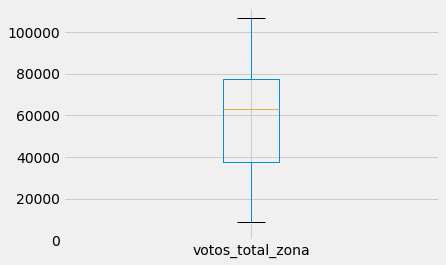

In [291]:
df.votos_total_zona[:,1].plot.box()
df.votos_total_zona[:,1].hist(bins=30)

p = figure(plot_width=400, plot_height=400)
p.vbar(x=[1, 2, 3], width=0.5, bottom=0,
       top=[1.2, 2.5, 3.7], color="firebrick")

show(p)

In [260]:
map_options = GMapOptions(
    lat=-22.645587, 
    lng=-43.072766, 
    map_type="roadmap", zoom=8
)

plot = GMapPlot(
    x_range=Range1d(), y_range=Range1d(), 
    map_options=map_options
)
plot.title.text = "Proporção de votos pelas zonas eleitorais (ZE's)"

plot.api_key = g_key

source = ColumnDataSource(data)
max_votos = data.votos.loc[data.votos.idxmax()]
min_votos = data.votos.loc[data.votos.idxmin()]

# color_mapper = CategoricalColorMapper(factors=['hi', 'lo'], palette=[RdBu3[2], RdBu3[0]])
color_mapper = LogColorMapper(
    palette="RdBu9", 
    low=min_votos, 
    high=max_votos
)
# color_mapper = LinearColorMapper(palette=Viridis5)

circle = Circle(x="lng", y="lat", size="votos", fill_color={
                    'field': 'votos', 
                    'transform': color_mapper
                },
                fill_alpha=0.5, line_color=None)
plot.add_glyph(source, circle)

color_bar = ColorBar(
    color_mapper=color_mapper, 
    ticker=BasicTicker(),
    label_standoff=12, 
    border_line_color=None, 
    location=(0,0)
)
plot.add_layout(color_bar, 'right')

hover = HoverTool(tooltips = [
    ('Bairro', '@bairro'),
    ('Zona', '@zona'),
    ('Votos', '@votos_total')
])



plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), hover)
plot.plot_width = 900
output_file("gmap_plot.html")
output_notebook()

show(plot)

GlyphRenderer(id='17026', ...)

Loading BokehJS ...

In [305]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   .ipynb_checkpoints/eleicoes-checkpoint.ipynb
	modified:   eleicoes.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.idea/
	gmap_plot.html
	table_votos.html

no changes added to commit (use "git add" and/or "git commit -a")
